# GDP spectral analysis

- [ ] velocity
- [ ] acceleration


In [9]:
import os

import numpy as np
import pandas as pd
import xarray as xr
import dask.dataframe as dd

import cartopy.crs as ccrs
import cartopy.feature as cfeature
import geopandas as gpd
from shapely.geometry import Polygon

%matplotlib inline
from matplotlib import pyplot as plt

import drifters.utils as ut
import pynsitu as pin

In [10]:
from dask.distributed import Client

if True :
    from dask_jobqueue import PBSCluster
    cluster = PBSCluster()
    w = cluster.scale(jobs=2) # 2 not enough for lon, lat, year, binning
else:
    from dask.distributed import LocalCluster
    cluster = LocalCluster()
    
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.PBSCluster
Dashboard: http://10.148.0.147:8787/status,
Dashboard: http://10.148.0.147:8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.148.0.147:45954,Workers: 0
Dashboard: http://10.148.0.147:8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


# load data

In [15]:
amp_v = 1e-1
amp_a = 1e-4
root_dir = "/home1/datawork/mdemol/GDP"
zarr_argos = os.path.join(root_dir, "argos_spectra.zarr")
zarr_gps = os.path.join(root_dir, "gps__spectra.zarr")
zarr_argos_noise = os.path.join(root_dir, f"argos_spectra_noise_{amp_v}_{amp_a}.zarr")
zarr_gps_noise = os.path.join(root_dir, f"gps_spectra_noise_{amp_v}_{amp_a}.zarr")

In [16]:
dsgps = xr.open_zarr(zarr_gps).persist()
dsargos = xr.open_zarr(zarr_argos).persist()
#dsgpsn = xr.open_zarr(zarr_gps_noise).persist()
dsargosn = xr.open_zarr(zarr_argos_noise).persist()

In [6]:
dsgps

<xarray.Dataset>
Dimensions:    (lon_bins: 359, lat_bins: 119, frequency: 1440)
Coordinates:
  * frequency  (frequency) float64 -12.0 -11.98 -11.97 ... 11.95 11.97 11.98
  * lat_bins   (lat_bins) float64 -59.5 -58.5 -57.5 -56.5 ... 56.5 57.5 58.5
  * lon_bins   (lon_bins) float64 -179.5 -178.5 -177.5 ... 176.5 177.5 178.5
Data variables:
    E_aen      (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(45, 15, 360), meta=np.ndarray>
    E_axy      (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(45, 15, 360), meta=np.ndarray>
    E_ven      (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(45, 15, 360), meta=np.ndarray>
    E_vxy      (lon_bins, lat_bins, frequency) float64 dask.array<chunksize=(45, 15, 360), meta=np.ndarray>

In [23]:
dsgps.E_aen.max().compute()

<xarray.DataArray 'E_aen' ()>
array(2.41373626e-07)

_________
# Sum on frequency 

In [28]:
def geo_plot(d_array,title='',legend='', vmax=60, ):
    fig = plt.figure(figsize=(15,5))
    ax = fig.add_subplot(1,1,1, projection=ccrs.EckertIII(central_longitude=-180))
    ax.add_feature(cfeature.LAND, zorder=2)
    d_array.rename(legend).plot(x="lon_bins", y="lat_bins", vmax=vmax, ax=ax, transform=ccrs.PlateCarree())
    ax.set_extent([1e-4, -1e-4, -60, 60], ccrs.PlateCarree())
    ax.set_title(title,fontsize=15)
    gl = ax.gridlines(draw_labels=True,)


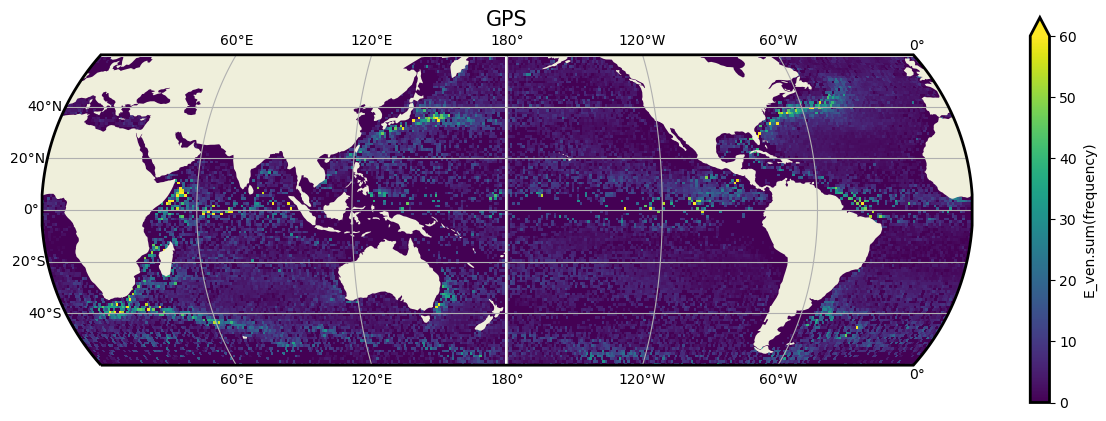

In [29]:
geo_plot(dsgps.E_ven.sum("frequency"), legend='E_ven.sum(frequency)', title='GPS',)

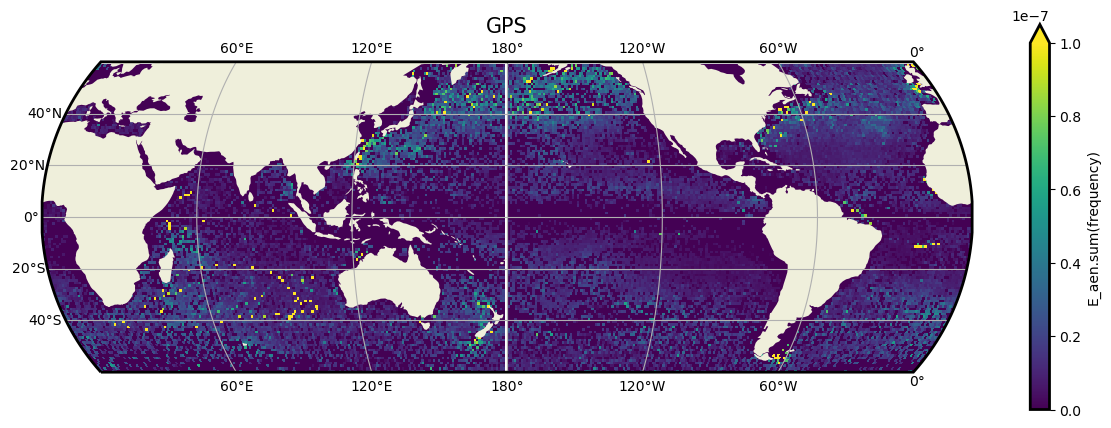

In [30]:
geo_plot(dsgps.E_aen.sum("frequency"), legend='E_aen.sum(frequency)', vmax=1e-7, title='GPS')

In [23]:
dsum = dsgps.sum("frequency")
dsum = dsum.where(dsum.E_aen>= 2e-07, drop=True)
dsel = dsum.E_aen.stack(x=['lat_bins','lon_bins'])
dsel = dsel[dsel.notnull()]
dsel

<xarray.DataArray 'E_aen' (x: 47)>
dask.array<getitem, shape=(47,), dtype=float64, chunksize=(4,), chunktype=numpy.ndarray>
Coordinates:
  * x         (x) object MultiIndex
  * lat_bins  (x) float64 -43.5 -41.5 -38.5 -38.5 -38.5 ... 52.5 55.5 57.5 58.5
  * lon_bins  (x) float64 31.5 19.5 76.5 91.5 92.5 ... -170.5 139.5 -159.5 -3.5

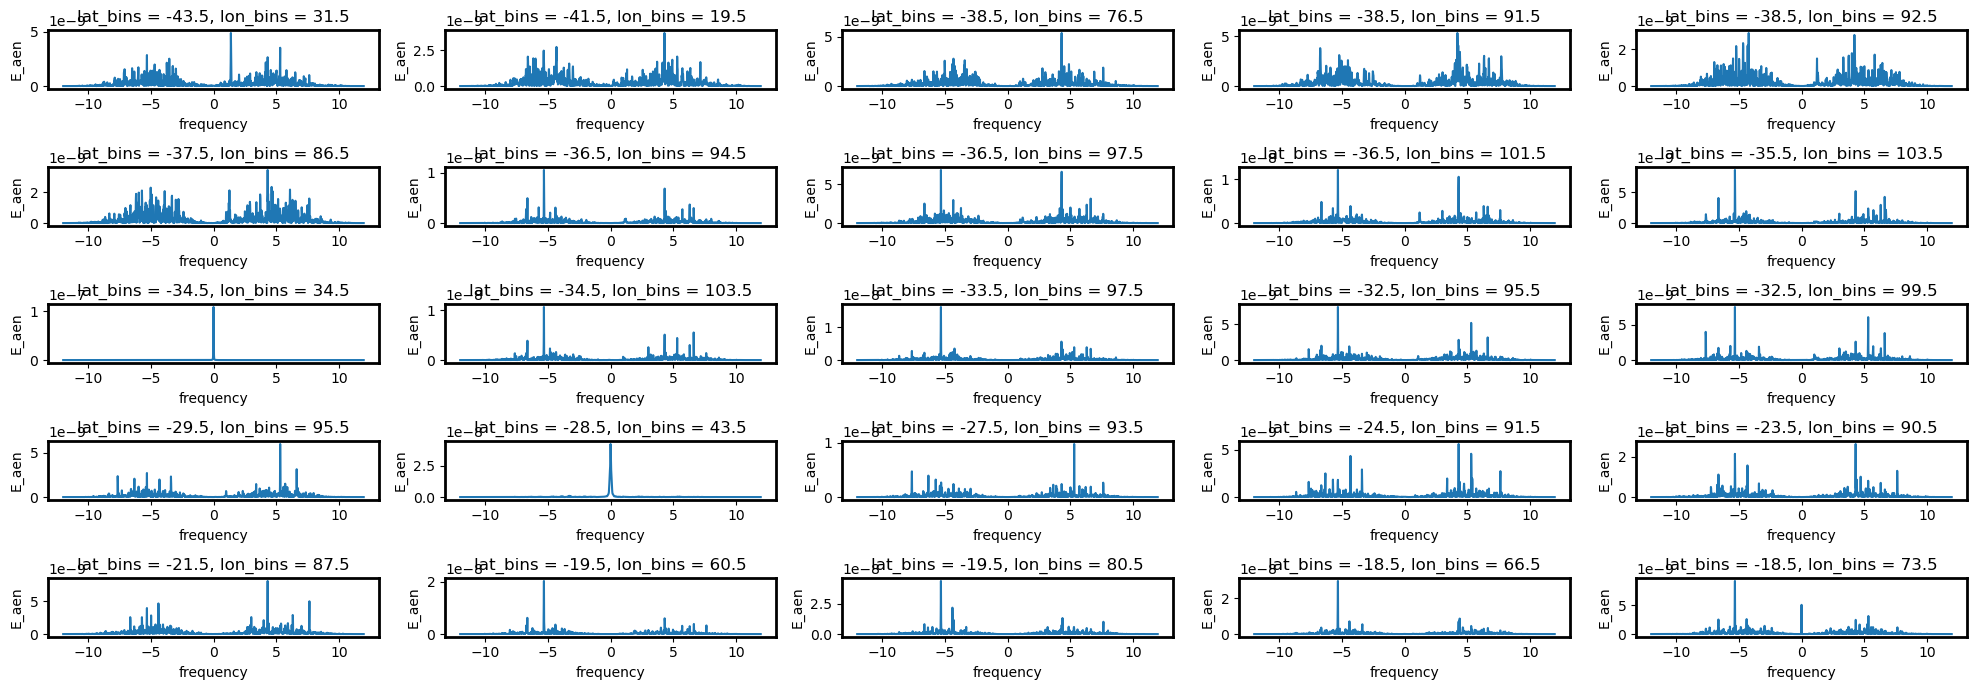

In [74]:
lat_bins_pb = [-43.5, -41.5, -38.5, -38.5, -38.5, -37.5, -36.5, -36.5, -36.5, -35.5,
       -34.5, -34.5, -33.5, -32.5, -32.5, -29.5, -28.5, -27.5, -24.5, -23.5,
       -21.5, -19.5, -19.5, -18.5, -18.5,   ]
lon_bins_pb = [  31.5,   19.5,   76.5,   91.5,   92.5,   86.5,   94.5,   97.5,  101.5,
        103.5,   34.5,  103.5,   97.5,   95.5,   99.5,   95.5,   43.5,   93.5,
         91.5,   90.5,   87.5,   60.5,   80.5,   66.5,   73.5,]
ds_pb = dsgps.sel(lat_bins=lat_bins_pb, lon_bins=lon_bins_pb)

from math import ceil
n = len(lat_bins_pb)
fig, ax = plt.subplots(ceil(n/5),5, figsize=(20,7))
ax=ax.flatten()
for i in range(n):
    ds_pb.isel(lat_bins = i, lon_bins = i).E_aen.plot(ax=ax[i])
fig.tight_layout(rect=[0,0,1,1])

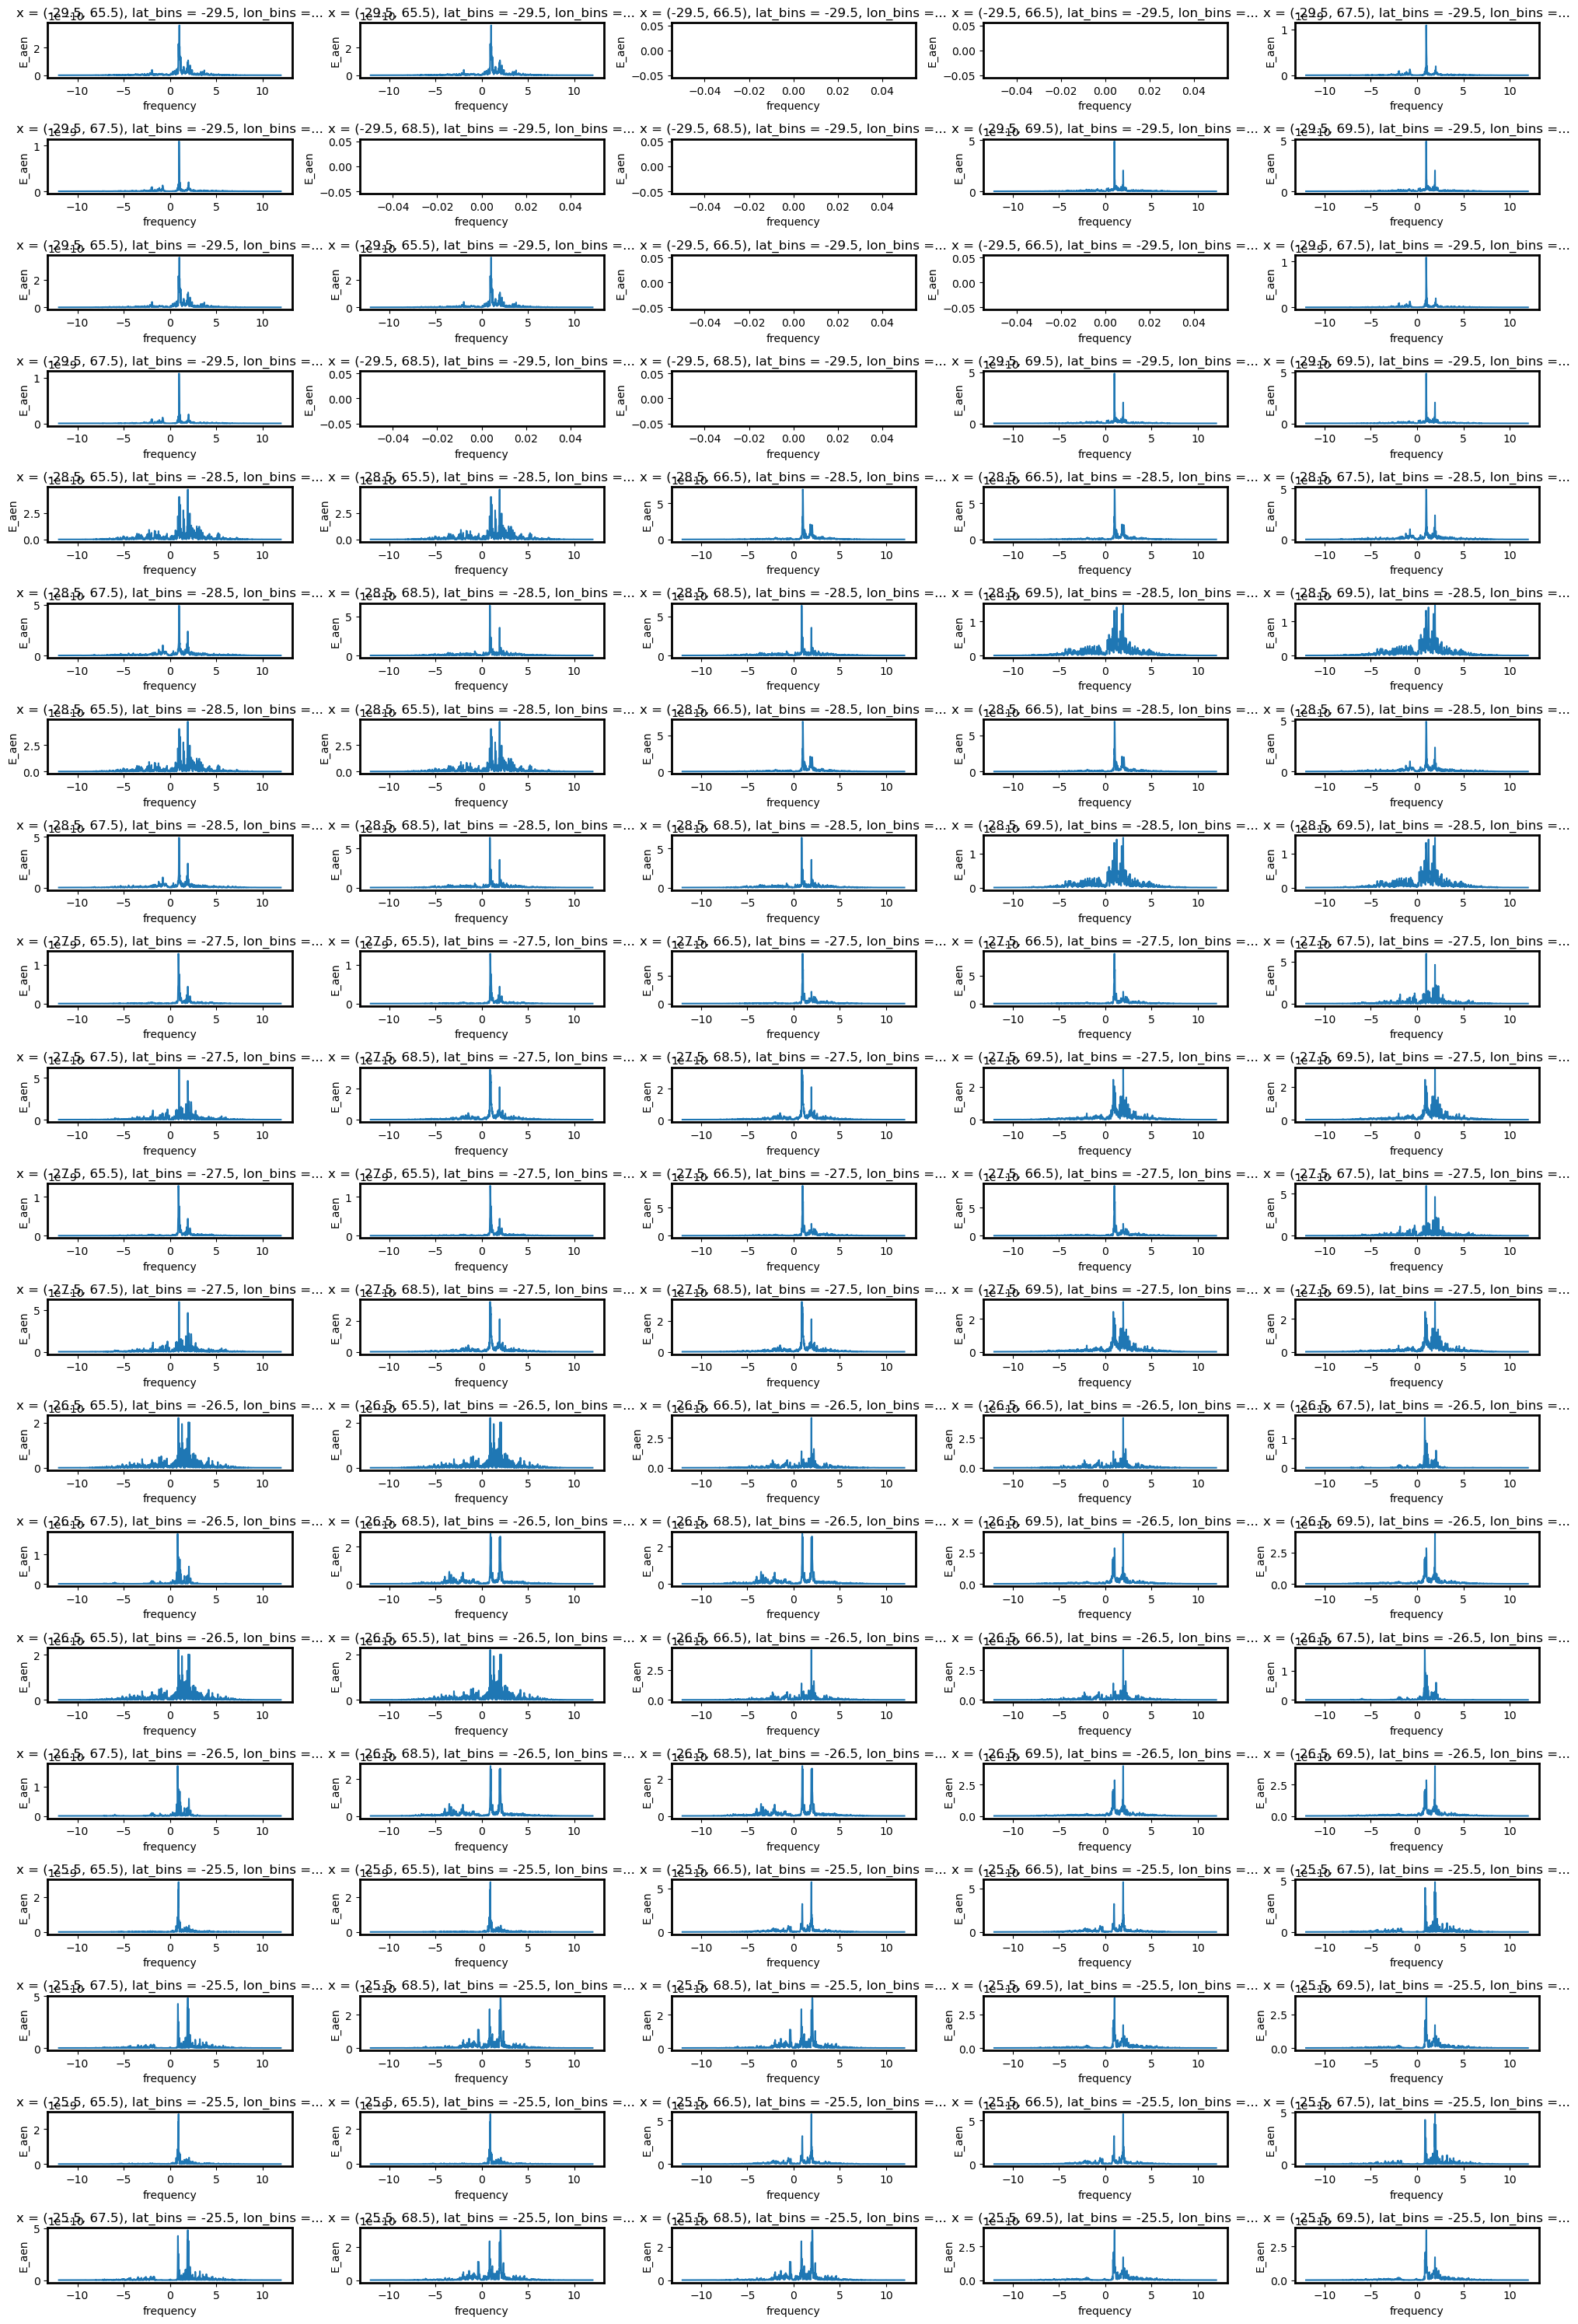

In [72]:
lon_b = np.arange(65,70, 0.5) 
lat_b = np.arange(-30,-25, 0.5) 
ds_npb = dsgps.sel(lat_bins=lat_b, lon_bins=lon_b, method = 'nearest').stack(x=['lat_bins','lon_bins'])
ds_npb
from math import ceil
n = 100
fig, ax = plt.subplots(ceil(n/5), 5, figsize=(20,30))
ax=ax.flatten()
for i in range(n):
    ds_npb.isel(x = i).E_aen.plot(ax=ax[i])
fig.tight_layout(rect=[0,0,1,1])

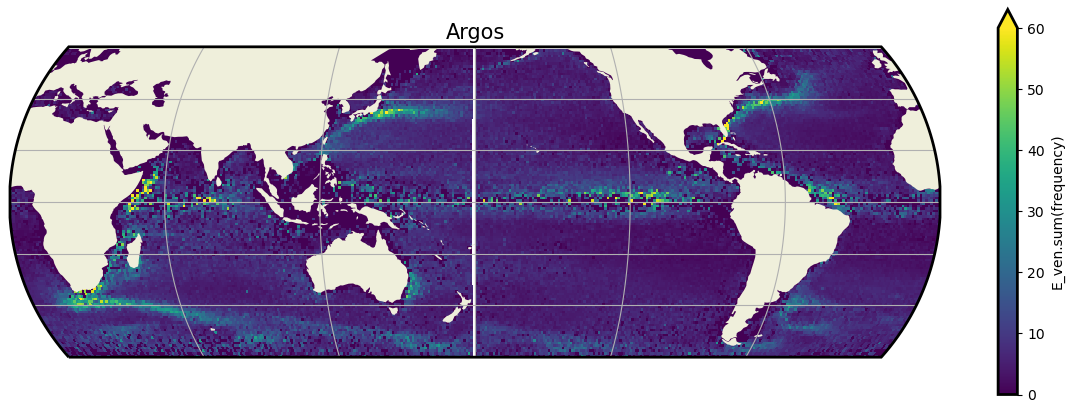

In [53]:
geo_plot(dsargos.E_ven.sum("frequency"), legend='E_ven.sum(frequency)', title='Argos')

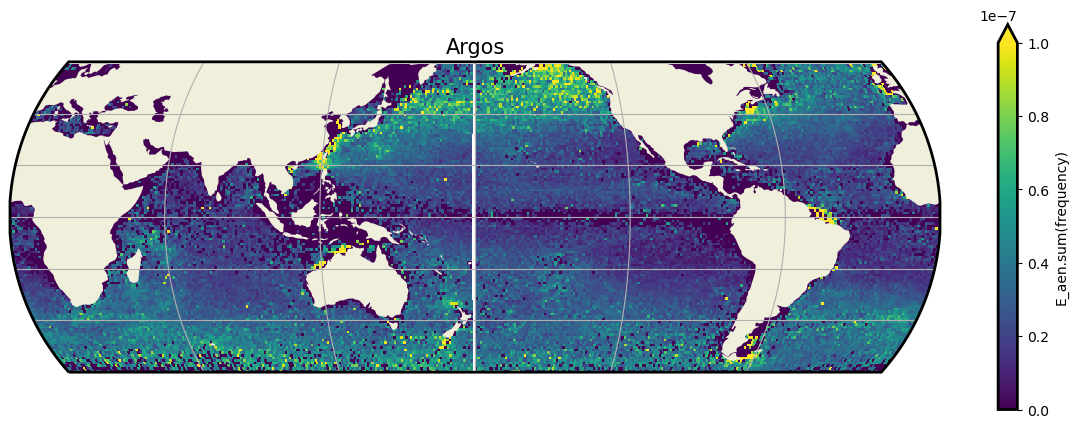

In [69]:
geo_plot(dsargos.E_aen.sum("frequency"), legend='E_aen.sum(frequency)', vmax=1e-7, title='Argos')

_____
# Spectra
## log

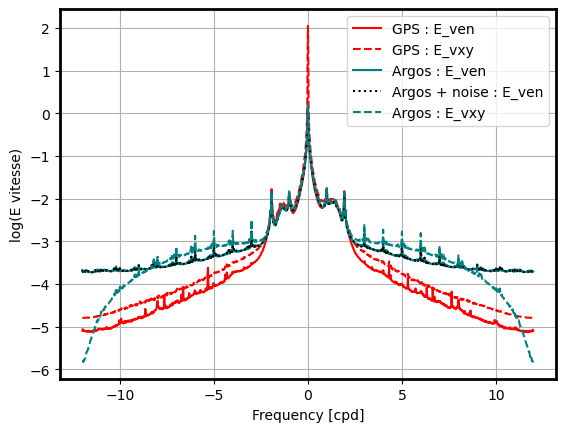

In [17]:
fig, ax = plt.subplots(1,1)
np.log10(dsgps.E_ven.mean(["lon_bins", "lat_bins"])).plot(label = 'GPS : E_ven', color='red')
#np.log10(dsgpsn.E_ven.mean(["lon_bins", "lat_bins"])).plot(label = 'GPS + noise : E_ven', color='k', ls=':')
np.log10(dsgps.E_vxy.mean(["lon_bins", "lat_bins"])).plot(label = 'GPS : E_vxy', color='red', ls='--')
np.log10(dsargos.E_ven.mean(["lon_bins", "lat_bins"])).plot(label = 'Argos : E_ven', color='teal')
np.log10(dsargosn.E_ven.mean(["lon_bins", "lat_bins"])).plot(label = 'Argos + noise : E_ven', color='k', ls=':')
np.log10(dsargos.E_vxy.mean(["lon_bins", "lat_bins"])).plot(label = 'Argos : E_vxy', color='teal', ls='--')
ax.grid()
ax.set_xlabel('Frequency [cpd]')
ax.set_ylabel('log(E vitesse)')
plt.legend()

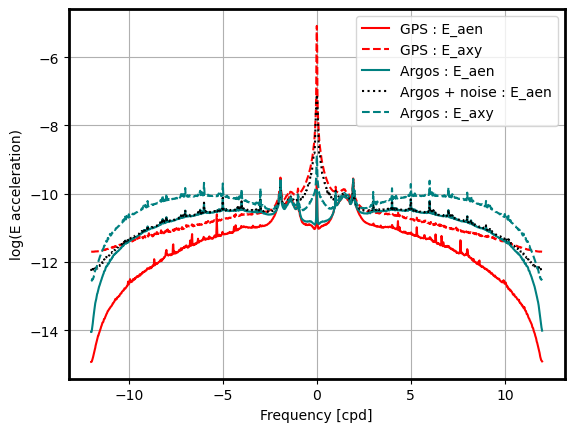

In [18]:
fig, ax = plt.subplots(1,1)
np.log10(dsgps.E_aen.mean(["lon_bins", "lat_bins"])).plot(label = 'GPS : E_aen', color='red')
#np.log10(dsgpsn.E_aen.mean(["lon_bins", "lat_bins"])).plot(label = 'GPS + noise : E_aen', color='red', ls=':')
np.log10(dsgps.E_axy.mean(["lon_bins", "lat_bins"])).plot(label = 'GPS : E_axy', color='red', ls='--')
np.log10(dsargos.E_aen.mean(["lon_bins", "lat_bins"])).plot(label = 'Argos : E_aen', color='teal')
np.log10(dsargosn.E_aen.mean(["lon_bins", "lat_bins"])).plot(label = 'Argos + noise : E_aen', color='k', ls=':')
np.log10(dsargos.E_axy.mean(["lon_bins", "lat_bins"])).plot(label = 'Argos : E_axy', color='teal', ls='--')
ax.grid()
ax.set_xlabel('Frequency [cpd]')
ax.set_ylabel('log(E acceleration)')
plt.legend()

## linear

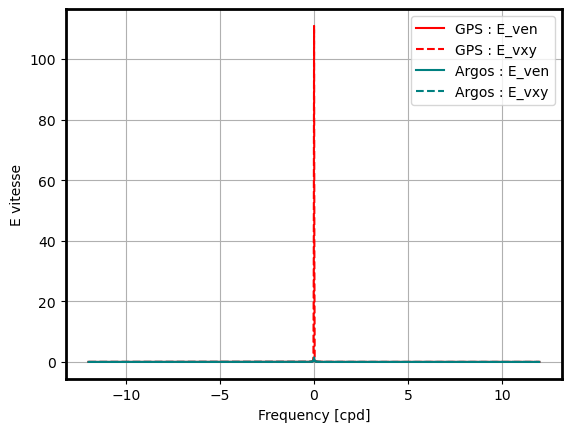

In [71]:
fig, ax = plt.subplots(1,1)
dsgps.E_ven.mean(["lon_bins", "lat_bins"]).plot(label = 'GPS : E_ven', color='red')
dsgps.E_vxy.mean(["lon_bins", "lat_bins"]).plot(label = 'GPS : E_vxy', color='red', ls='--')
dsargos.E_ven.mean(["lon_bins", "lat_bins"]).plot(label = 'Argos : E_ven', color='teal')
dsargos.E_vxy.mean(["lon_bins", "lat_bins"]).plot(label = 'Argos : E_vxy', color='teal', ls='--')
ax.grid()
ax.set_xlabel('Frequency [cpd]')
ax.set_ylabel('E vitesse')
plt.legend()

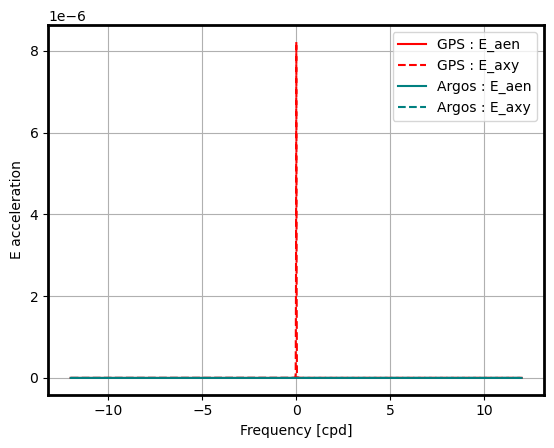

In [72]:
fig, ax = plt.subplots(1,1)
dsgps.E_aen.mean(["lon_bins", "lat_bins"]).plot(label = 'GPS : E_aen', color='red')
dsgps.E_axy.mean(["lon_bins", "lat_bins"]).plot(label = 'GPS : E_axy', color='red', ls='--')
dsargos.E_aen.mean(["lon_bins", "lat_bins"]).plot(label = 'Argos : E_aen', color='teal')
dsargos.E_axy.mean(["lon_bins", "lat_bins"]).plot(label = 'Argos : E_axy', color='teal', ls='--')
ax.grid()
ax.set_xlabel('Frequency [cpd]')
ax.set_ylabel('E acceleration')
plt.legend()

# Spectra lat

In [28]:
#d_lat = dsgps.sum('lon_bins').compute()#.plot()
d_lat = dsargos.sum('lon_bins').compute()#.plot()

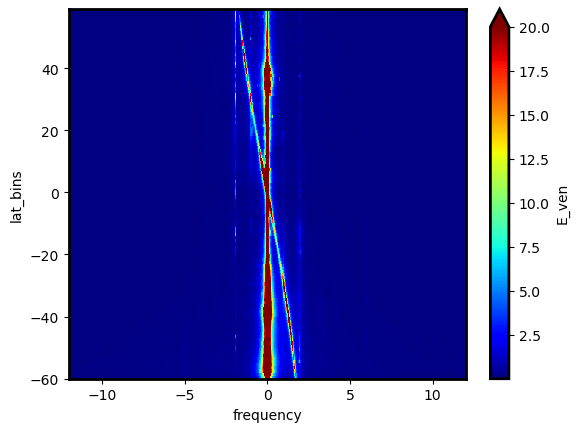

In [29]:
d_lat.E_ven.plot(cmap='jet', vmax=20)

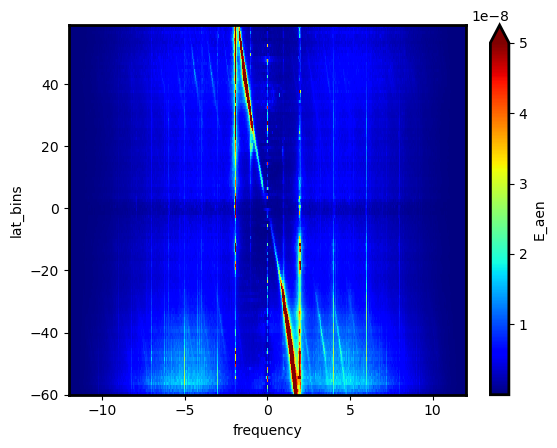

In [30]:
d_lat.E_aen.plot(cmap='jet', vmax=5e-8)

In [19]:
cluster.close()

distributed.client - ERROR - Failed to reconnect to scheduler after 10.00 seconds, closing client
